<a href="https://colab.research.google.com/github/Stavroskiig/AUTOENCODER-CIFAR-10/blob/main/NN_3rd_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

3η Υποχρεωτική Εργασία


---
* **Στόχος**:
Ζητούμενο της εργασίας είναι να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα **δίκτυο αυτοκωδικοποίησης (autoencoder)**. Το δίκτυο αυτό θα εκπαιδευτεί για να επιλύει το πρόβλημα επανακατασκευής των 10 κλάσεων του **CIFAR-10**. Στη συνέχεια θα εκπαιδευτεί το SVM της προηγούμενης εργασίας για να λύσει το πρόβλημα ταξινόμησης 2 κλάσεων.

* **Γλώσσα**:
Επιλέγω να εργαστώ σε **Python**.

* **Βάση Δεδομένων**:
Για την εκπαίδευση και την επανακατασκευή αποφάσισα να χρησιμοποιήσω την βάση δεδομένων CIFAR-10 που υπάρχει στην παρακάτω διεύθυνση:
https://www.cs.toronto.edu/~kriz/cifar.html


---



# Προεπεξεργασία του CIFAR-10

Παίρνω το dataset από την keras. Βεβαίως απαιτείται πρώτα να εισάγω την TensorFLow.



In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Αυτό μου επιστρέφει:
* **x_train**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (50000, 32, 32, 3), που περιέχουν τα δεδομένα εκπαίδευσης (train). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_train**: uint8 NumPy πίνακας ετικετών (labels) (ακέραιοι του εύρους 0-9) με shape (50000, 1) για τα δεδομένα εκπαίδευσης (train).

* **x_test**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (10000, 32, 32, 3), που περιέχουν τα δεδομένα δοκιμής (test). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_test**: uint8 NumPy πίνακας ετικετών (ακέραιοι στο εύρος 0-9) με shapes (10000, 1) για τα δεδομένα δοκιμής (test).

Θα δω τα shapes των συνόλων. Τα `x` σύνολα περιλαμβάνουν τις εικόνες, ενώ τα `y` τις ετικέτες.

In [2]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


* Τα `x_train` και `x_test` έχουν το shape: (πλήθος εικόνων, ύψος, πλάτος, πλήθος καναλιών).
* Τα `y_train` και `y_test` είναι 2D πίνακες με shape: (πλήθος εικόνων, 1)

Μετατρέπω τα σύνολα σε `float32`.

In [3]:
import numpy as np
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [4]:
number_features = 3072

x_train = x_train.reshape([-1, number_features])
x_test = x_test.reshape([-1, number_features])

print("x_train:", x_train.shape, "x_test:", x_test.shape)

x_train: (50000, 3072) x_test: (10000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [5]:
x_train = x_train/255.0
x_test = x_test/255.0

Κρατώ τον αριθμό των κλάσεων για το μέλλον.

In [6]:
number_classes = 10

---

Ιδανικά ανοίξτε το notebook στο colab για να φαίνονται και οι εικόνες που ετοίμασα (είναι ανεβασμένες στο drive λόγω χώρου).
https://colab.research.google.com/drive/1Lcj-_pExSvRS659_Pcsq-mLBz4gDodAU?usp=sharing

---

# Ο Αλγόριθμος Autoencoder

Οι αυτοκωδικοποιητές είναι ένας ειδικός τύπος feedforward νευρωνικών δικτύων, όπου η είσοδος είναι ίδια με την έξοδο. Συμπιέζουν την είσοδο σε έναν κώδικα χαμηλότερης διάστασης και στη συνέχεια ανακατασκευάζουν την έξοδο από αυτήν την αναπαράσταση. Ο κώδικας είναι μια συμπαγής "σύνοψη" ή "συμπίεση" της εισόδου, που ονομάζεται επίσης αναπαράσταση latent-space.

Ένας αυτοκωδικοποιητής αποτελείται από 3 στοιχεία: τον κωδικοποιητή, τον κώδικα και τον αποκωδικοποιητή. Ο κωδικοποιητής συμπιέζει την είσοδο και παράγει τον κωδικό, ο αποκωδικοποιητής στη συνέχεια ανακατασκευάζει την είσοδο χρησιμοποιώντας αυτόν τον κωδικό.

![alt](https://drive.google.com/uc?id=1Vwtml9v2avGCL1gM_KPunaYIauws_fBN)

Για να δημιουργήσω έναν αυτοκωδικοποιητή χρειάζονται 3 μέρη: μια μέθοδος κωδικοποίησης, μια μέθοδος αποκωδικοποίησης και μια συνάρτηση απώλειας για να συγκρίνω την έξοδο με τον στόχο.

Οι αυτοκωδικοποιητές ουσιαστικά είναι ένας αλγόριθμος μείωσης διαστάσεων (ή συμπίεσης). Οι κύριες ιδιότητες τους είναι:

* **Εξειδίκευση**: Οι αυτοκωδικοποιητές μπορούν να συμπιέσουν μόνο δεδομένα παρόμοια με αυτά στα οποία έχουν εκπαιδευτεί. Δεδομένου ότι μαθαίνουν χαρακτηριστικά ειδικά για τα δεδομένα εκπαίδευσης, διαφέρουν από έναν τυπικό αλγόριθμο συμπίεσης δεδομένων. Επομένως, δεν μπορούμε να περιμένουμε από έναν αυτοκωδικοποιητή εκπαιδευμένο σε φωτογραφίες να συμπιέζει χειρόγραφα ψηφία.

* **Απώλεια**: Η έξοδος του αυτοκωδικοποιητή δεν θα είναι ακριβώς ίδια με την είσοδο, θα είναι παρόμοια, αλλά υποβαθμισμένη αναπαράσταση.

* **Χωρίς επίβλεψη**: Οι αυτοκωδικοποιητές θεωρούνται μια τεχνική εκμάθησης χωρίς επίβλεψη, καθώς δεν χρειάζονται ετικέτες κλάσεων για την εκπαίδευση. Επιβλέπονται από τον εαυτό τους επειδή δημιουργούν τις δικές τους ετικέτες από τα δεδομένα εκπαίδευσης.

Τόσο ο κωδικοποιητής όσο και ο αποκωδικοποιητής είναι πλήρως συνδεδεμένα feedforward νευρωνικά δίκτυα. Ο κώδικας είναι ένα μονό στρώμα ενός ΑΝΝ με τις διαστάσεις που θέλω. Ο αριθμός των κόμβων στο στρώμα κώδικα (μέγεθος κώδικα) είναι μια υπερπαράμετρος που ορίζω πριν εκπαιδεύσω τον αυτοκωδικοποιητή.

![alt](https://drive.google.com/uc?id=1R10b9Few64SQzVUdni0q_iRaERLS1Iyu)

Πρώτα η είσοδος περνά μέσα από τον κωδικοποιητή, ο οποίος είναι ένα πλήρως συνδεδεμένο ANN, για να παραχθεί ο κώδικας. Ο αποκωδικοποιητής, ο οποίος έχει παρόμοια δομή ANN, παράγει τότε την έξοδο χρησιμοποιώντας τον κώδικα. Ο στόχος είναι να ληφθεί μια έξοδος ίδια με την είσοδο. Συνήθως η αρχιτεκτονική του αποκωδικοποιητή είναι αντίστοιχη του κωδικοποιητή, αλλά αυτό δεν είναι αναγκαστικό. Η μόνη απαίτηση είναι η διάσταση της εισόδου και της εξόδου πρέπει να είναι η ίδια.

Πριν εκπαιδεύσω έναν αυτοκωδικοποιητή ορίζω 4 υπερπαραμέτρους:

* **Μέγεθος κώδικα**: αριθμός κόμβων στο μεσαίο στρώμα. Το μικρότερο μέγεθος οδηγεί σε μεγαλύτερη συμπίεση.

* **Αριθμός στρωμάτων**: ο αυτοκωδικοποιητής μπορεί να είναι όσο βαθύς θέλω. Στο παραπάνω σχήμα υπάρχουν 2 στρώματα, τόσο στον κωδικοποιητή όσο και στον αποκωδικοποιητή, χωρίς να μετράω την είσοδο και την έξοδο.

* **Αριθμός κόμβων ανά επίπεδο**: η αρχιτεκτονική του αυτοκωδικοποιητή που δουλεύω ονομάζεται stacked autoencoder (στοιβαγμένος αυτοκωδικοποιητής), καθώς τα επίπεδα στοιβάζονται το ένα μετά το άλλο. Συνήθως αυτοί οι αυτοκωδικοποιητές μοιάζουν με "σάντουιτς". Ο αριθμός των κόμβων ανά επίπεδο μειώνεται με κάθε επόμενο επίπεδο του κωδικοποιητή και αυξάνεται ξανά στον αποκωδικοποιητή.

* **Συνάρτηση απώλειας**: χρησιμοποιώ είτε μέσο τετραγωνικό σφάλμα (mse), είτε binary crossentropy. Εάν οι τιμές εισόδου είναι στην περιοχή [0, 1] τότε χρησιμοποιώ crossentropy, διαφορετικά χρησιμοποιώ το μέσο τετράγωνο σφάλμα.

# Autoencoder

Εδώ θα ορίσω και θα εκπαιδεύσω μια αρχιτεκτονική autoencoder για ανακατασκευή εικόνων. Το μοντέλο περιλαμβάνει επίπεδα κωδικοποίησης και αποκωδικοποίησης και το μέσο τετραγωνικό σφάλμα (MSE) χρησιμοποιείται ως συνάρτηση απώλειας.

Πρώτα επιβεβαιώνω τα shapes των συνόλων μου και τις ετικέτες ώστε να συνεχίσω.

In [7]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 3072)
y_train shape: (50000, 1)
x_test shape: (10000, 3072)
y_test shape: (10000, 1)


In [8]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))

Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_test: [0 1 2 3 4 5 6 7 8 9]


Γίνονται και τα κατάλληλα imports.

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time

## **Αρχιτεκτονική του αυτοκωδικοποιητή**

* **Είσοδος:**

Στο `encoder_input` ορίζω την είσοδο στον αυτοκωδικοποιητή που έχει διάσταση ίση με τα features, δηλαδή 3072.

* **Κωδικοποιητής:**

Αποτελείται από δύο πυκνά στρώματα, το πρώτο έχει 512 νευρώνες και συνάρτηση ενεργοποίησης την Rectified Linear Unit (ReLU), η οποία εισάγει την μη γραμμικότητα στο μοντέλο. Το δεύτερο στρώμα έχει 256 νευρώνες. Και πάλι, το ReLU χρησιμοποιείται ως συνάρτηση ενεργοποίησης.

* **Αποκωδικοποιητής:**

Αποτελείται αρχικά από ένα στρώμα που αντικατοπτρίζει το πρώτο πυκνό στρώμα του κωδικοποιητή, αλλά χρησιμοποιεί την έξοδο του κωδικοποιημένου στρώματος ως είσοδο, δηλαδή τον κώδικα. Ξανά, η συνάρτηση ενεργοποίησης είναι το ReLU.

Έπειτα έχει ένα πυκνό στρώμα που παράγει την έξοδο του αυτοκωδικοποιητή. Ο αριθμός των νευρώνων σε αυτό το επίπεδο έχει οριστεί σε number_features, που είναι ίδιος με τον αριθμό των χαρακτηριστικών στα δεδομένα εισόδου, καθώς όπως είπα αυτό είναι το μόνο απαιτούμενο. Εδώ η συνάρτηση ενεργοποίησης είναι η σιγμοειδής.



In [10]:
encoder_input = layers.Input(shape=(x_train.shape[1],))
x = layers.Dense(512, activation='relu')(encoder_input)
encoded = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(encoded)
decoded = layers.Dense(number_features, activation='sigmoid')(x)

autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

Τώρα θα δείξω μια περίληψη του μοντέλου που περιλαμβάνει τα στρώματα, τα shapes των διαφόρων εξόδων και τις παραμέτρους.

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 3072)              1575936   
                                                                 
Total params: 3412224 (13.02 MB)
Trainable params: 3412224 (13.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Αξιολόγηση

Εκπαιδεύω το μοντέλο για 10 εποχές και μετά το αξιολογώ με βάση την απώλεια.

In [12]:
start = time.time()

history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

end = time.time()
print("Training time: {} seconds\n".format(end - start))

evaluation = autoencoder.evaluate(x_test, x_test)
print("\nAutoencoder Evaluation - Loss:", evaluation)

Epoch 1/10
391/391 [==============================] - 57s 140ms/step - loss: 0.0274 - val_loss: 0.0161
Epoch 2/10
391/391 [==============================] - 33s 85ms/step - loss: 0.0143 - val_loss: 0.0128
Epoch 3/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 4/10
391/391 [==============================] - 34s 86ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 5/10
391/391 [==============================] - 32s 82ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 6/10
391/391 [==============================] - 34s 88ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 7/10
391/391 [==============================] - 33s 84ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 8/10
391/391 [==============================] - 34s 87ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 9/10
391/391 [==============================] - 33s 84ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/10
391/391 [==============================] - 32s 82ms/step - loss: 0.00

Αναπαριστώ γραφικά τα training, validation losses.

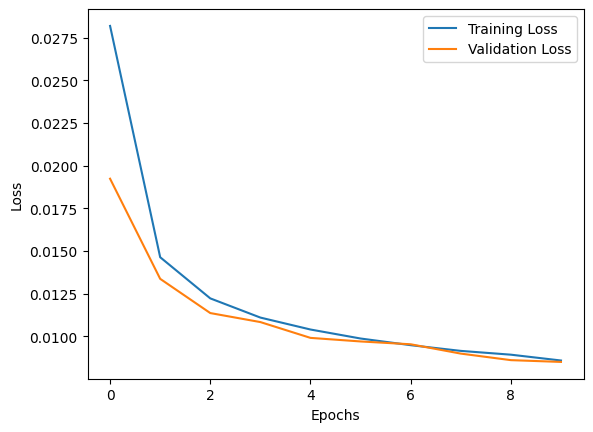

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Προβολή εικόνων

Δείχνω και 10 ανακατασκευασμένες εικόνες.

313/313 [==============================] - 5s 14ms/step


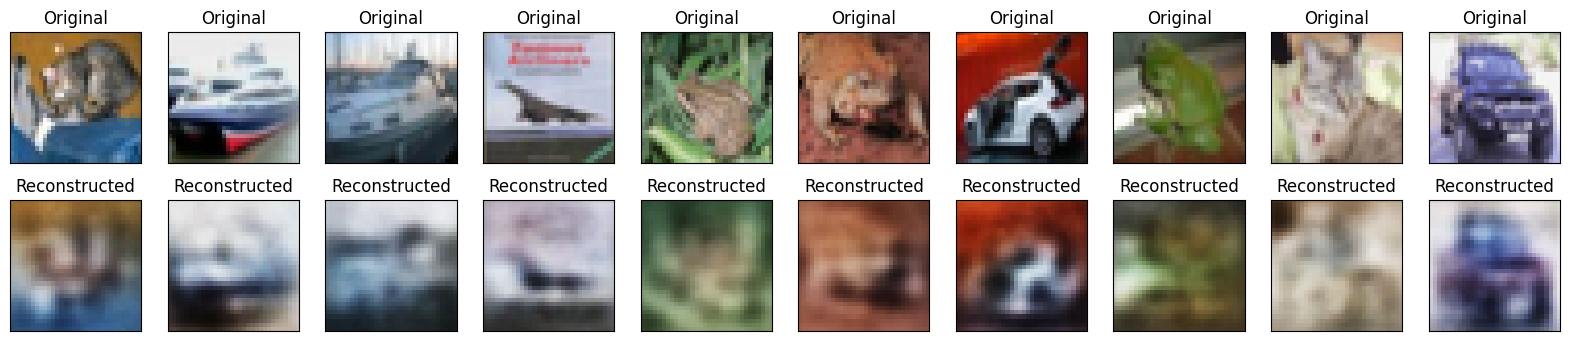

In [14]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# PCA Reconstruction

Στην συνέχεια της εργασίας εφαρμόζω PCA στα δεδομένα εκπαίδευσης και δοκιμής, ώστε να τα επανακατασκευάσω χρησιμοποιώντας τα μετασχηματισμένα στοιχεία . Τελικά αξιολογώ την διαδικασία με βάση την απώλεια.

* **Εφαρμογή PCA**

In [16]:
from sklearn.decomposition import PCA

start = time.time()

pca = PCA(n_components=0.9).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

end = time.time()
print("PCA elapsed time: {} seconds\n".format(end - start))
print("Extracted {} features from the original {}.".format(x_train_pca.shape[1], x_train.shape[1]))
print("Cumulative explained variation for {} principal components: {:.2%}".format(x_train_pca.shape[1], np.sum(pca.explained_variance_ratio_)))

PCA elapsed time: 77.93389844894409 seconds

Extracted 99 features from the original 3072.
Cumulative explained variation for 99 principal components: 90.03%


Κρατώντας μόλις 99 features από τα 3072, δηλαδή το 3.22%, καταφέρνω να κρατήσω περισσότερο από το 90% της πληροφορίας.

* **Επανακατασκευή**

Ουσιαστικά θα κάνω `inverse_transform`. Δέχεται σαν είσοδο πίνακα της μορφής (n_samples, n_components), όπου `n_samples` είναι ο αριθμός των δειγμάτων και `n_components` είναι ο αριθμός των χαρακτηριστικών. Επιστρέφει πίνακα μορφής (n_samples, n_features), όπου `n_samples` είναι ο αριθμός των δειγμάτων και `n_features` είναι ο αριθμός των χαρακτηριστικών.

In [17]:
x_train_pca_reconstructed = pca.inverse_transform(x_train_pca)
x_test_pca_reconstructed = pca.inverse_transform(x_test_pca)

* **Αξιολόγηση**

In [20]:
start = time.time()
pca_evaluation_train = np.mean(np.square(x_train - x_train_pca_reconstructed))
end = time.time()
print("PCA reconstruction elapsed time: {} seconds".format(end - start))

pca_evaluation_test = np.mean(np.square(x_test - x_test_pca_reconstructed))

print("\nPCA Reconstruction Evaluation - Training Set Loss:", pca_evaluation_train)
print("PCA Reconstruction Evaluation - Test Set Loss:", pca_evaluation_test)

PCA reconstruction elapsed time: 2.0933616161346436 seconds

PCA Reconstruction Evaluation - Training Set Loss: 0.006178189
PCA Reconstruction Evaluation - Test Set Loss: 0.006201869


Τώρα θα προβάλω τις ανακατασκευασμένες εικόνες τόσο από το PCA, όσο και από τον autoencoder.

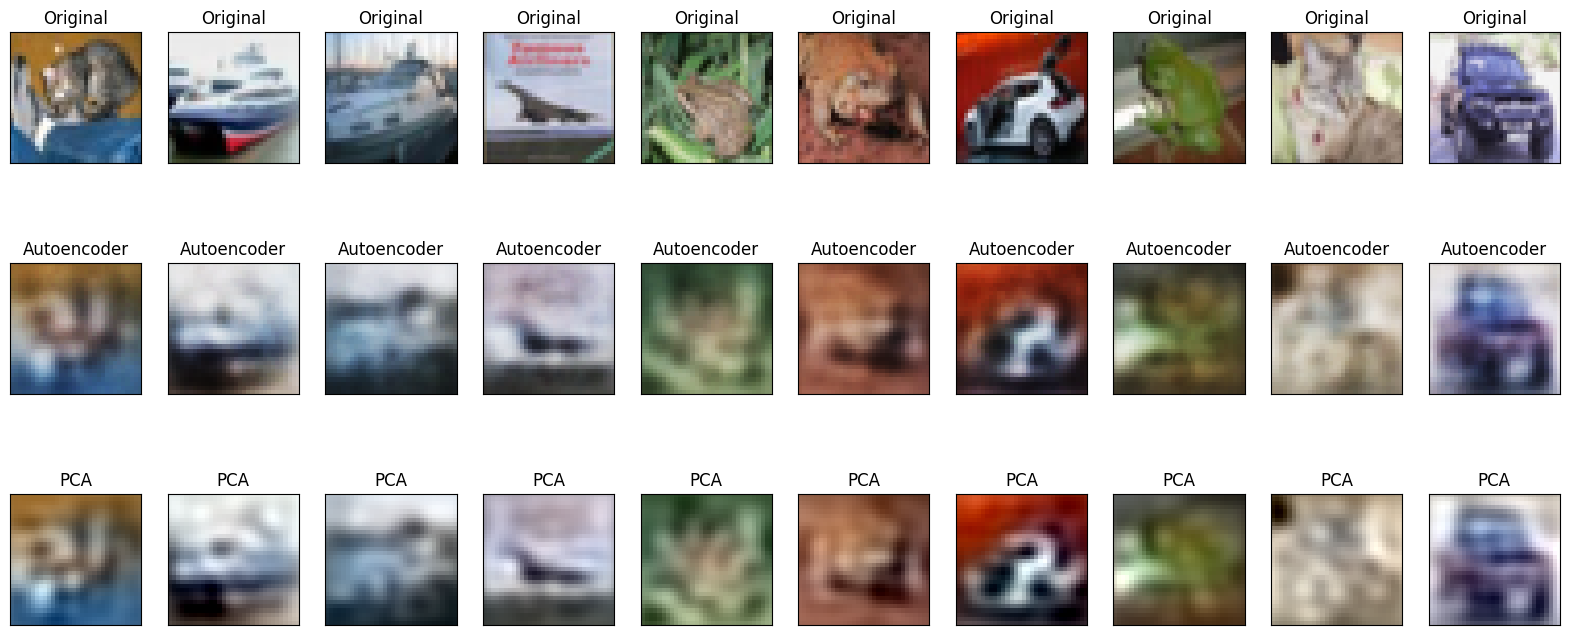

In [21]:
n = 10
plt.figure(figsize=(20, 8))  # figure size and spacing
plt.subplots_adjust(hspace=0.5)  # vertical spacing

for i in range(n):

    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.title("Autoencoder")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(np.clip(x_test_pca_reconstructed[i].reshape(32, 32, 3), 0, 1))
    plt.title("PCA")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Παρατηρώ ότι η ανακατασκευή από τον αυτοκωδικοποιητή είναι ελάχιστα καλύτερη. Φαίνεται από την 4η εικόνα που έχει κείμενο πως είναι λίγο πιο λεπτομερής. Θα ακολουθήσει fine-tuning για να δω αν μπορεί να βελτιωθεί.

# Fine-Tune Autoencoder

Θα χρησιμοποιήσω το optuna framework, όπως και στις προηγούμενες εργασίες.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow import keras
from keras import layers, models
import tensorflow as tf
from sklearn.decomposition import PCA

Μέσα στην αντικειμενική συνάρτηση πρώτα καθορίζω τις υπερπαραμέτρους προς βελτιστοποίηση.Δηλαδή τον αριθμό των νευρώνων στον κωδικοποιητή και τον αποκωδικοποιητή, τη συνάρτηση ενεργοποίησης και τον ρυθμό εκμάθησης.

Μετά ορίζω την αρχιτεκτονική του αυτοκωδικοποιητή με τις υπό μελέτη υπερπαραμέτρους που ορίζονται από το Optuna.

Εκπαιδεύω και αξιολογώ τον αυτοκωδικοποιητή χρησιμοποιώντας τις καθορισμένες υπερπαραμέτρους. Τελικά επιστρέφω την μετρική αξιολόγησης.

In [ ]:
def objective(trial):

    units_encoder = trial.suggest_int('units_encoder', 128, 512)
    units_decoder = trial.suggest_int('units_decoder', 128, 512)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    encoder_input = layers.Input(shape=(x_train.shape[1],))
    x = layers.Dense(units_encoder, activation=activation)(encoder_input)
    encoded = layers.Dense(units_decoder, activation=activation)(x)
    x = layers.Dense(units_encoder, activation=activation)(encoded)
    decoded = layers.Dense(number_features, activation='sigmoid')(x)

    autoencoder = models.Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, validation_data=(x_test, x_test), verbose=0)

    evaluation = autoencoder.evaluate(x_test, x_test)

    return evaluation

Ορίζω την μελέτη του Optuna έχοντας ως στόχο την ελαχιστοποίησης της αντικειμενικής συνάρτησης. Εξαιτίας περιορισμένων πόρων και χρόνου επιλέγω να τρέξει για 15 διαφορετικά σετ τιμών.

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("Best trial:")
trial = study.best_trial
print("  Value: {:.5f}".format(trial.value))
print("  Params: {}".format(trial.params))

[I 2024-01-03 13:15:20,641] A new study created in memory with name: no-name-2328217c-59fd-42c0-9287-603fcdf6d77b


313/313 [==============================] - 1s 5ms/step - loss: 0.0184


[I 2024-01-03 13:16:46,955] Trial 0 finished with value: 0.01840653084218502 and parameters: {'units_encoder': 154, 'units_decoder': 402, 'activation': 'sigmoid', 'learning_rate': 9.173158398272564e-05}. Best is trial 0 with value: 0.01840653084218502.


313/313 [==============================] - 2s 7ms/step - loss: 0.0069


[I 2024-01-03 13:19:14,050] Trial 1 finished with value: 0.006923303008079529 and parameters: {'units_encoder': 467, 'units_decoder': 284, 'activation': 'relu', 'learning_rate': 2.2402197615419213e-05}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 2s 7ms/step - loss: 0.0176


[I 2024-01-03 13:20:40,908] Trial 2 finished with value: 0.01762162707746029 and parameters: {'units_encoder': 180, 'units_decoder': 488, 'activation': 'sigmoid', 'learning_rate': 5.7988373888419534e-05}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 1s 5ms/step - loss: 0.0184


[I 2024-01-03 13:22:07,289] Trial 3 finished with value: 0.01836175099015236 and parameters: {'units_encoder': 155, 'units_decoder': 392, 'activation': 'sigmoid', 'learning_rate': 0.0085133090367242}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 2s 5ms/step - loss: 0.0183


[I 2024-01-03 13:23:06,173] Trial 4 finished with value: 0.018291359767317772 and parameters: {'units_encoder': 161, 'units_decoder': 368, 'activation': 'sigmoid', 'learning_rate': 8.980636048678182e-05}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 1s 4ms/step - loss: 0.0087


[I 2024-01-03 13:23:56,174] Trial 5 finished with value: 0.008686547167599201 and parameters: {'units_encoder': 130, 'units_decoder': 401, 'activation': 'relu', 'learning_rate': 0.009885974418416836}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 2s 5ms/step - loss: 0.0168


[I 2024-01-03 13:26:23,411] Trial 6 finished with value: 0.016799498349428177 and parameters: {'units_encoder': 387, 'units_decoder': 146, 'activation': 'sigmoid', 'learning_rate': 0.00026105988289673387}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 2s 8ms/step - loss: 0.0164


[I 2024-01-03 13:28:50,233] Trial 7 finished with value: 0.01641225442290306 and parameters: {'units_encoder': 349, 'units_decoder': 172, 'activation': 'sigmoid', 'learning_rate': 0.005709911341891638}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 2s 6ms/step - loss: 0.0178


[I 2024-01-03 13:29:50,711] Trial 8 finished with value: 0.01777217723429203 and parameters: {'units_encoder': 206, 'units_decoder': 159, 'activation': 'sigmoid', 'learning_rate': 0.0026987375577311717}. Best is trial 1 with value: 0.006923303008079529.


313/313 [==============================] - 3s 9ms/step - loss: 0.0069


[I 2024-01-03 13:32:11,107] Trial 9 finished with value: 0.006893129087984562 and parameters: {'units_encoder': 502, 'units_decoder': 398, 'activation': 'relu', 'learning_rate': 2.3229413155401076e-05}. Best is trial 9 with value: 0.006893129087984562.


313/313 [==============================] - 3s 9ms/step - loss: 0.0069


[I 2024-01-03 13:34:38,213] Trial 10 finished with value: 0.006879683118313551 and parameters: {'units_encoder': 500, 'units_decoder': 506, 'activation': 'relu', 'learning_rate': 1.1271581164660937e-05}. Best is trial 10 with value: 0.006879683118313551.


313/313 [==============================] - 2s 7ms/step - loss: 0.0070


[I 2024-01-03 13:37:05,962] Trial 11 finished with value: 0.007027945481240749 and parameters: {'units_encoder': 496, 'units_decoder': 503, 'activation': 'relu', 'learning_rate': 1.3227562488514087e-05}. Best is trial 10 with value: 0.006879683118313551.


313/313 [==============================] - 3s 9ms/step - loss: 0.0069


[I 2024-01-03 13:39:32,938] Trial 12 finished with value: 0.006892422679811716 and parameters: {'units_encoder': 430, 'units_decoder': 453, 'activation': 'relu', 'learning_rate': 1.097586278305144e-05}. Best is trial 10 with value: 0.006879683118313551.


313/313 [==============================] - 2s 7ms/step - loss: 0.0069


[I 2024-01-03 13:42:01,173] Trial 13 finished with value: 0.006899319589138031 and parameters: {'units_encoder': 427, 'units_decoder': 464, 'activation': 'relu', 'learning_rate': 1.0196357514036481e-05}. Best is trial 10 with value: 0.006879683118313551.


313/313 [==============================] - 3s 9ms/step - loss: 0.0071


[I 2024-01-03 13:43:20,317] Trial 14 finished with value: 0.007063599303364754 and parameters: {'units_encoder': 287, 'units_decoder': 262, 'activation': 'relu', 'learning_rate': 0.00046361147350789674}. Best is trial 10 with value: 0.006879683118313551.


Best trial:
  Value: 0.00688
  Params: {'units_encoder': 500, 'units_decoder': 506, 'activation': 'relu', 'learning_rate': 1.1271581164660937e-05}


Η καλύτερη δοκιμή έδωσε την απώλεια: **0.00688** και προκύπτει από τις υπερπαραμέτρους:

*{'units_encoder': 500, 'units_decoder': 506, 'activation': 'relu', 'learning_rate': 1.1271581164660937e-05}*

## Build the best Autoencoder

Με βάση τα προηγούμενα αποτελέσματα θα φτιάξω τον "βέλτιστο" αυτοκωδικοποιητή. Βεβαίως περιμένω η απώλεια να είναι διαφορετικά, καθώς υπάρχει η στοχαστικότητα.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 500)               1536500   
                                                                 
 dense_1 (Dense)             (None, 506)               253506    
                                                                 
 dense_2 (Dense)             (None, 500)               253500    
                                                                 
 dense_3 (Dense)             (None, 3072)              1539072   
                                                                 
Total params: 3582578 (13.67 MB)
Trainable params: 3582578 (13.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
391/391 [=

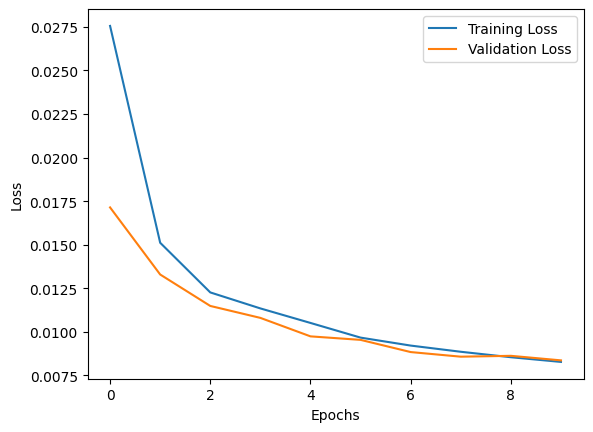

313/313 [==============================] - 3s 10ms/step


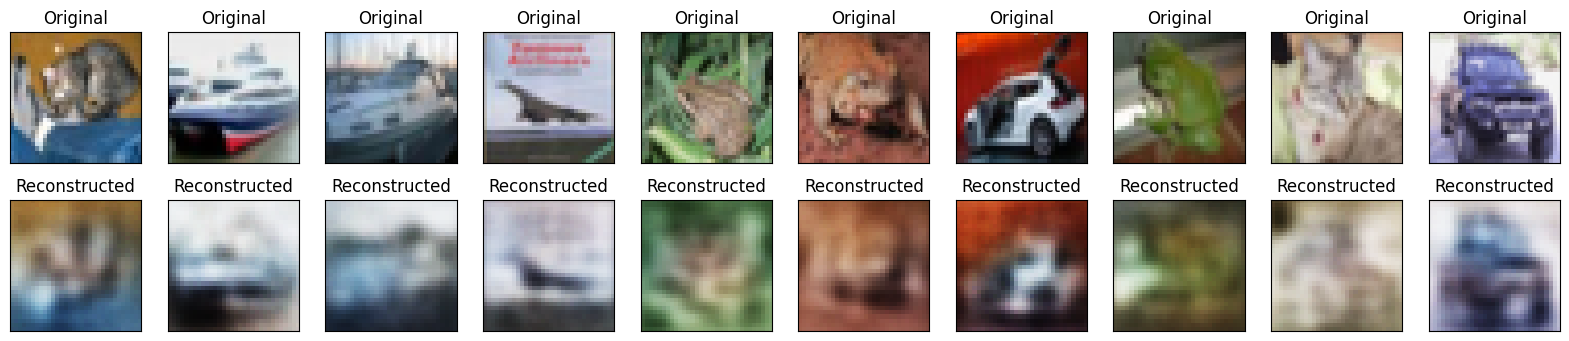

In [ ]:
units_encoder = 500
units_decoder = 506
activation = 'relu'
learning_rate = 1.1271581164660937e-05

encoder_input = layers.Input(shape=(x_train.shape[1],))
x = layers.Dense(units_encoder, activation=activation)(encoder_input)
encoded = layers.Dense(units_decoder, activation=activation)(x)
x = layers.Dense(units_encoder, activation=activation)(encoded)
decoded = layers.Dense(number_features, activation='sigmoid')(x)

autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

evaluation = autoencoder.evaluate(x_test, x_test)
print("\nAutoencoder Evaluation - Loss:", evaluation)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Ταξινόμηση Ανακατασκευασμένων Εικόνων

Πλέον απομένει το classification των επανακατασκευασμένων εικόνων. Η διαδικασία που θα ακολουθήσω είναι παρόμοια με τα προηγούμενα. Η μόνη διαφορά είναι πως για την ταξινόμηση θα χρησιμοποιήσω το SVM της 2ης εργασίας στο σύνολο των δύο κλάσεων.

In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Θέλω να διατηρήσω μόνο δύο κλάσεις από το σύνολο δεδομένων CIFAR-10. Για αυτό θα φιλτράρω τα δεδομένα με βάση τις κλάσεις που θέλετε να κρατήσω. Επιλέγω τα αεροπλάνα (index 0) και τα πλοία (index 8).

In [ ]:
chosen_classes = [0, 8]

Ορίζω την συνάρτηση φιλτραρίσματος, η οποία παίρνει ως παραμέτρους ένα σύνολο x και τις κλάσεις που έχω επιλέξει. Το tf.equal επιστρέφει έναν boolean τένσορα με την τιμή True όπου η κλάση του παραδείγματος ταιριάζει με τις επιλεγμένες κλάσεις, ενώ False στις υπόλοιπες.

In [ ]:
import numpy as np

def filter_dataset(x, y, chosen_classes):
    y = y.flatten()
    train_mask = np.isin(y, chosen_classes)
    x_filtered = x[train_mask]
    y_filtered = y[train_mask]
    return x_filtered, y_filtered

Τώρα φιλτράρω τα σύνολα.

In [ ]:
x_train_filtered, y_train_filtered = filter_dataset(x_train, y_train, chosen_classes)
x_test_filtered, y_test_filtered = filter_dataset(x_test, y_test, chosen_classes)

In [ ]:
print(x_train.shape, x_train_filtered.shape)
print(y_train.shape, y_train_filtered.shape)

print(x_test.shape, x_test_filtered.shape)
print(y_test.shape, y_test_filtered.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000,)
(10000, 32, 32, 3) (2000, 32, 32, 3)
(10000, 1) (2000,)


Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [ ]:
number_features = 3072

x_train_filtered = x_train_filtered.reshape([-1, number_features])
x_test_filtered = x_test_filtered.reshape([-1, number_features])

print("x_train:", x_train_filtered.shape, "x_test:", x_test_filtered.shape)

x_train: (10000, 3072) x_test: (2000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [ ]:
x_train_filtered = x_train_filtered/255.0
x_test_filtered = x_test_filtered/255.0

In [ ]:
units_encoder = 500
units_decoder = 506
activation = 'relu'
learning_rate = 1.1271581164660937e-05

encoder_input = layers.Input(shape=(x_train_filtered.shape[1],))
x = layers.Dense(units_encoder, activation=activation)(encoder_input)
encoded = layers.Dense(units_decoder, activation=activation)(x)
x = layers.Dense(units_encoder, activation=activation)(encoded)
decoded = layers.Dense(number_features, activation='sigmoid')(x)

autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train_filtered, x_train_filtered, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test_filtered, x_test_filtered))


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense_8 (Dense)             (None, 500)               1536500   
                                                                 
 dense_9 (Dense)             (None, 506)               253506    
                                                                 
 dense_10 (Dense)            (None, 500)               253500    
                                                                 
 dense_11 (Dense)            (None, 3072)              1539072   
                                                                 
Total params: 3582578 (13.67 MB)
Trainable params: 3582578 (13.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
79/79 [=

In [ ]:
train_decoded = autoencoder.predict(x_train_filtered)

313/313 [==============================] - 5s 16ms/step


In [ ]:
test_decoded = autoencoder.predict(x_test_filtered)

63/63 [==============================] - 1s 10ms/step


In [ ]:
print(train_decoded.shape)
print(test_decoded.shape)

(10000, 3072)
(2000, 3072)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

start_time = time.time()
svm = SVC(C=100, kernel='rbf', gamma=0.001, coef0=1.0, degree=5)
svm.fit(train_decoded, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(train_decoded)

train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

start_time = time.time()
y_test_pred = svm.predict(test_decoded)
testing_time = time.time() - start_time

test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print("\nClassification Report:")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Time: {testing_time:.2f} seconds")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))


Classification Report:
Training Time: 186.65 seconds
Training Accuracy: 85.30%
Testing Time: 36.73 seconds
Test Accuracy: 81.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1000
           8       0.80      0.83      0.81      1000

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



# Προβλέψεις

Θα προβάλλω και θα συγκρίνω τις πραγματικές κλάσεις και τις προβλεπόμενες κλάσεις για ένα υποσύνολο εικόνων χρησιμοποιώντας το εκπαιδευμένο μοντέλο SVM. Επιλέγω να δείξω 10 εικόνες μαζί με τις πραγματικές τους κλάσεις και τις αντίστοιχες προβλεπόμενες. Κάνω reshape στις εικόνες στις αρχικές διαστάσεις 32x32x3. Στην λίστα `cifar10_labels` βάζω τις κλάσεις για το σύνολο δεδομένων CIFAR-10.

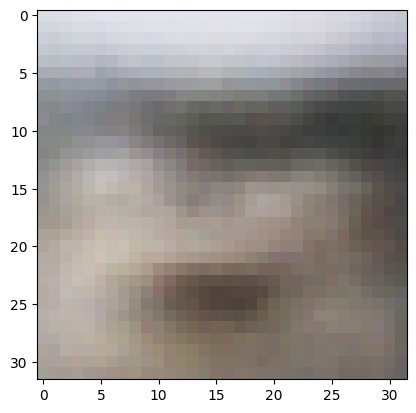

Actual class: ship, Predicted class: ship


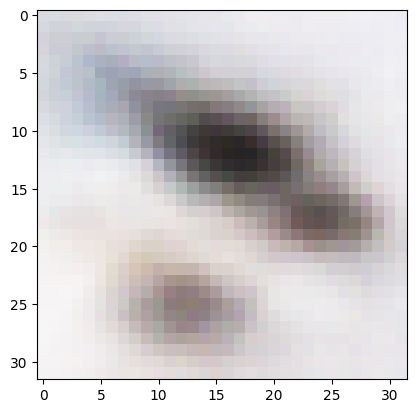

Actual class: airplane, Predicted class: airplane


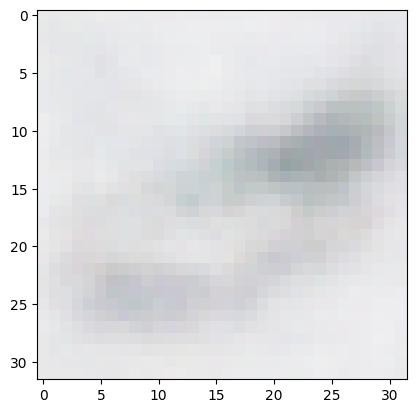

Actual class: ship, Predicted class: airplane


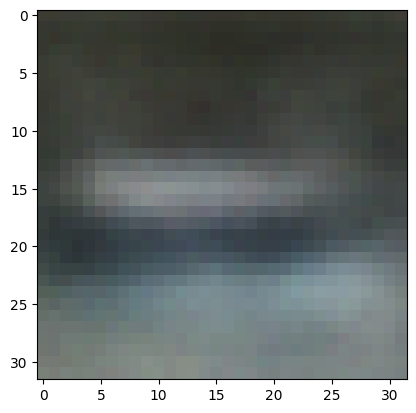

Actual class: ship, Predicted class: airplane


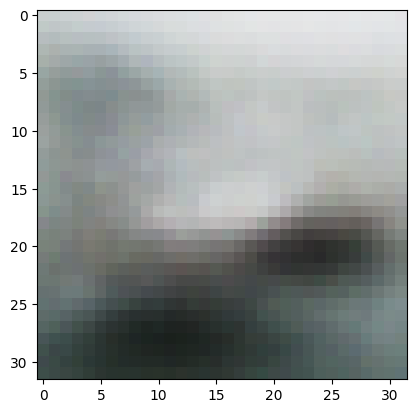

Actual class: ship, Predicted class: ship


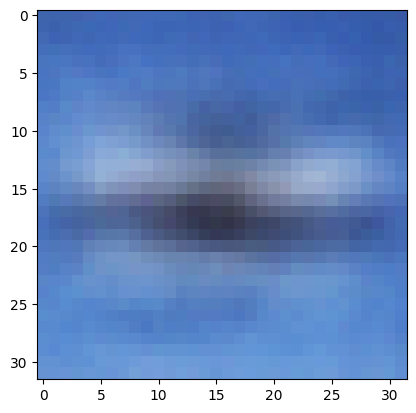

Actual class: airplane, Predicted class: airplane


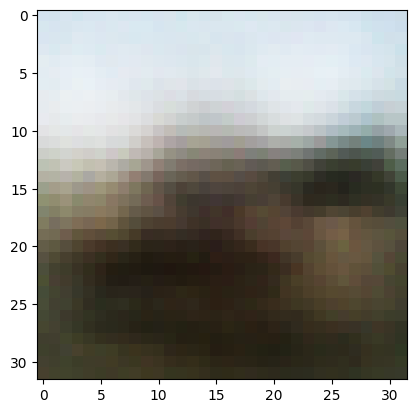

Actual class: airplane, Predicted class: airplane


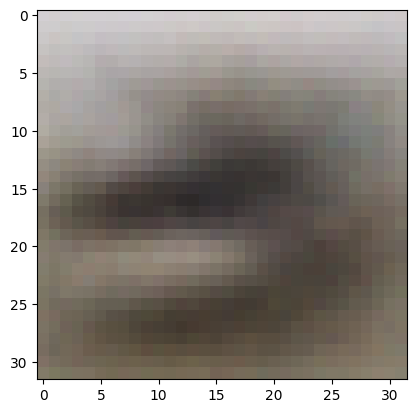

Actual class: ship, Predicted class: airplane


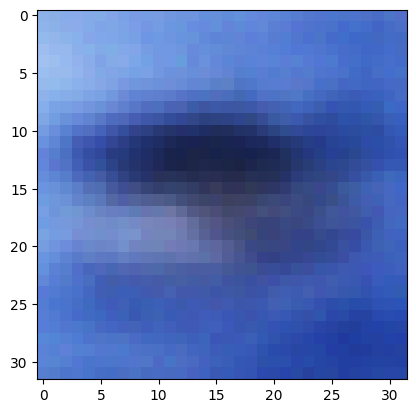

Actual class: airplane, Predicted class: airplane


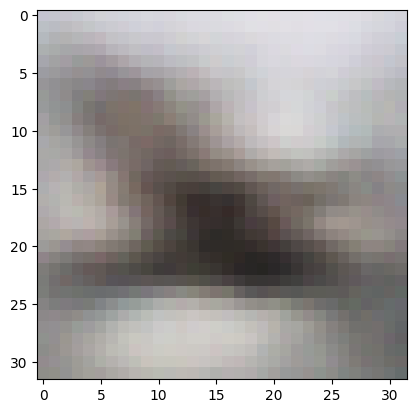

Actual class: airplane, Predicted class: airplane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

start_index = 50
end_index = 60

for i in range(start_index, end_index):
    plt.imshow(test_decoded[i].reshape(32, 32, 3))
    plt.show()

    actual_class = cifar10_labels[y_test_filtered[i].item()]
    predicted_class = cifar10_labels[y_test_pred[i].item()]

    print("Actual class: {}, Predicted class: {}".format(actual_class, predicted_class))

Βλέπως πως στις συγκεκριμένες εικόνες είχε 70% επιτυχία. Προφανώς σε κάθε εκτέλεση λόγω στοχαστικότητας τα αποτελέσματα θα αλλάζουν λίγο. Επίσης, είναι ξεκάθαρο πως παίζει ρόλο και η επιλογή των συγκεκριμένων κλάσεων και των εικόνων.

Γενικά τα αποτελέσματα είναι ευχάριστα καθώς πετυχαίνει καλά αποτελέσματα για εικόνες τόσο χαμηλής ανάλυσης. Ενδεχομένως να είναι και καλύτερο από το ανθρώπινο μάτι.